# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from SVMKit import SVM
from SVM_evaluation import plot_confusion_matrix,select_best_configuration,plot_decision_boundary

# Question 2

Write a program to find the solution to the SVM dual quadratic problem. Apply k-fold
cross validation for identifying the values of the hyperparameters C and γ. To find the
solution of the SVM dual quadratic problem, you should use a specific method for convex
optimization, such as CVXOPT.

In [2]:
# Load the dataset
gender = pd.read_csv("GENDER_CLASSIFICATION.csv")

In [3]:
# Features and labels
X = gender.drop("gt", axis=1).values #remove the target variable to keep only features
print(f"Dataset shape: {X.shape[0]} samples, {X.shape[1]} features")

y = gender["gt"].replace(0, -1).values  # Convert to -1, +1 labels

# Standardize features
scaler = StandardScaler()

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Print some informations about the shape of each set
print(f"\nClass distribution in training set: y = +1: {(y_train == 1).sum()} samples , y = -1: {(y_train == -1).sum()} samples")
print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"\nClass distribution in Test set: y = +1: {(y_test == 1).sum()} samples , y = -1: {(y_test == -1).sum()} samples")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")


Dataset shape: 1000 samples, 32 features

Class distribution in training set: y = +1: 400 samples , y = -1: 400 samples
Training set size: 800 samples, 32 features

Class distribution in Test set: y = +1: 100 samples , y = -1: 100 samples
Test set size: 200 samples, 32 features


## 2.1 SVM - Cross Validation

**Warning: the running time to search for the best parameters configuration is approximately  1 minute 30 seconds with k = 5 folds and 36 seconds with k = 3.**

In [4]:
kernels = [{
            "name": "gaussian",
            "param_grid": [{"gamma": g} for g in [0.01, 0.1, 1]]},

        {
            "name": "polynomial",
            "param_grid": [{"degree": p} for p in [2, 3, 4]]}]

C =  [0.1, 1, 10]

# Select best kernel using cross-validation
print("\nKernel selection and hyperparameter tuning")
best_config, all_results = select_best_configuration(X_train, y_train,solver="cvxopt",k=3,kernel_configurations=kernels , C_values=C)

print("\nBest Overall Configuration:")
print(f"Kernel: {best_config['kernel']}")
print(f"Parameters: {best_config['parameters']}")


Kernel selection and hyperparameter tuning
Testing kernel: gaussian
Best gaussian Kernel Accuracy: 0.918
Testing kernel: polynomial
Best polynomial Kernel Accuracy: 0.915


,kernel,C,gamma,accuracy,degree
0,gaussian,0.1,0.01,0.918,NaN
1,gaussian,0.1,0.10,0.916,NaN
4,gaussian,1.0,0.10,0.915,NaN
6,gaussian,10.0,0.01,0.915,NaN
9,polynomial,0.1,NaN,0.915,2.0
3,gaussian,1.0,0.01,0.915,NaN
7,gaussian,10.0,0.10,0.914,NaN
5,gaussian,1.0,1.00,0.911,NaN
2,gaussian,0.1,1.00,0.911,NaN
12,polynomial,1.0,NaN,0.910,2.0



Best Overall Configuration:
Kernel: gaussian
Parameters: {'C': 0.1, 'gamma': 0.01}



Final Model:

Dual objective (initial): 0.00
Dual objective (final): 19.78
Number of Iterations: 16
Bias: -0.20
Number of Support Vectors: 238
Max alpha value: 0.1
Min non-zero alpha: 0.0
CPU Time: 0.49 seconds

Accuracy Results:
Training Accuracy: 0.917
Test Accuracy: 0.925
Duality gap: 0.040



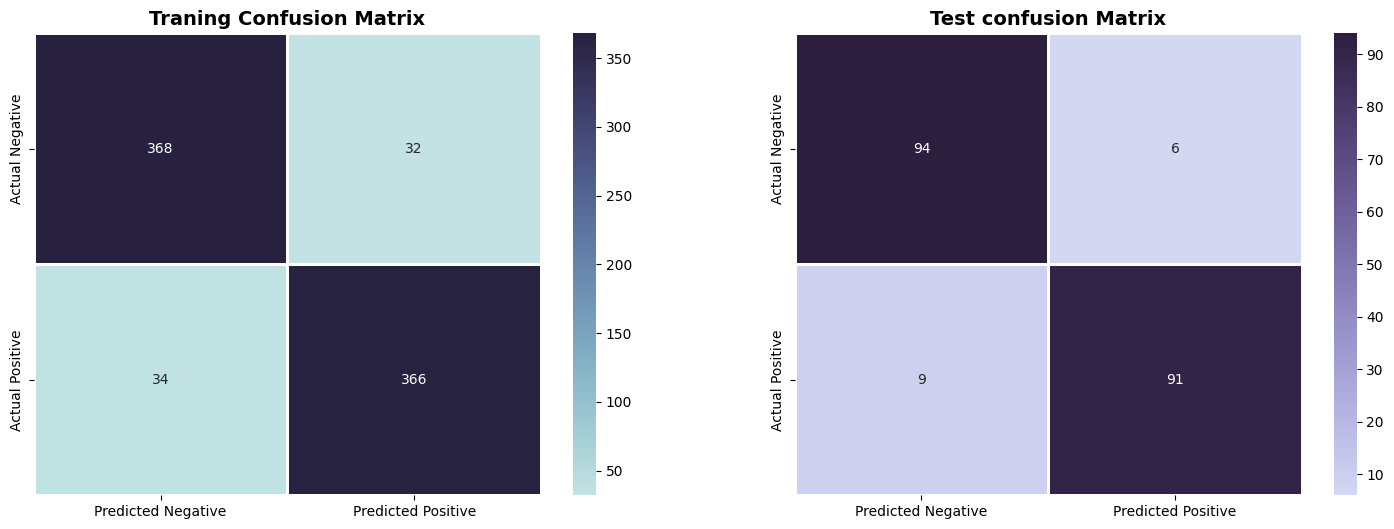

In [5]:
# Extract the best Kernel and parameters
kernel_name = best_config['kernel']
C = best_config['parameters']['C']

# Set kernel parameters
if kernel_name == 'gaussian':
    gamma = best_config['parameters']['gamma']
    svm = SVM(kernel='gaussian', C=C, gamma=gamma)
elif kernel_name == 'polynomial':
    degree = best_config['parameters']['degree']
    svm = SVM(kernel='polynomial', C=C, degree=degree)
else:
    raise ValueError("Unsupported kernel type.")

# Train the final model
svm.fit(X_train, y_train)

# Calculate accuracies
y_train_pred = svm.predict(X_train)
train_accuracy = svm.score(y_train_pred, y_train)

y_test_pred = svm.predict(X_test)
test_accuracy = svm.score(y_test_pred, y_test)

print("\nFinal Model:\n")
svm.report_metrics()

print(f"\nAccuracy Results:")
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Duality gap: {svm.duality_gap:.3f}\n")

plot_confusion_matrix(y_train,y_train_pred,y_test,y_test_pred)

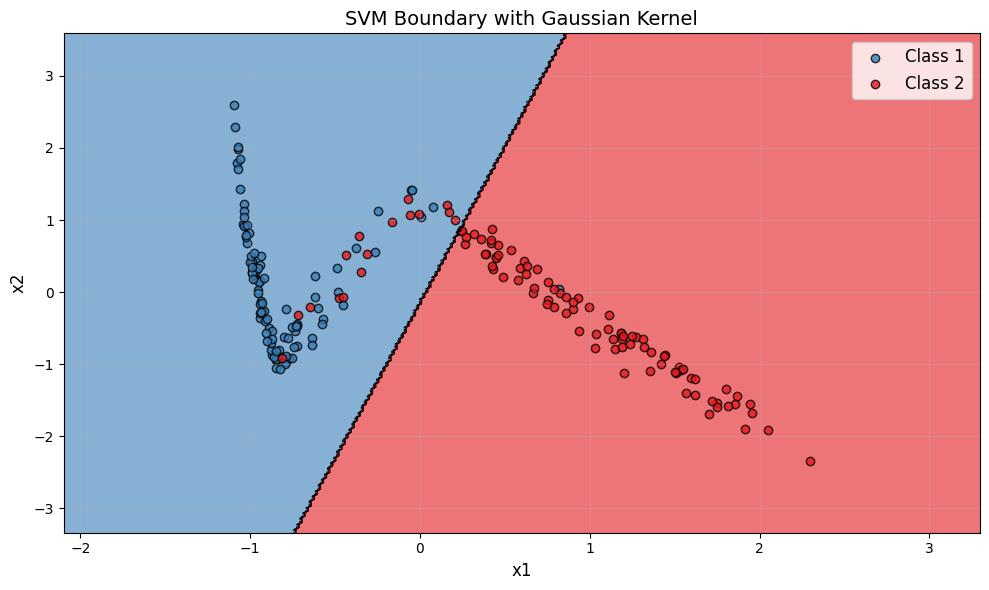

In [6]:
X = X_test[:,:2]  # Use only the first two features for visualization
y = y_test
svm.fit(X, y)  # Retrain SVM on the two features for visualization

plot_decision_boundary(svm, X, y,title="SVM Boundary with Gaussian Kernel")

# Question 3

Fix the dimension of the subproblem to q = 2 and implement the most violating pair
(MVP) decomposition method, which uses the analytic solution of the subproblems.


## 3.1 Test Different Tolerance

In [7]:
tolerances = [1e-3, 1e-5, 1e-7]

tol_results = []
for tol in tolerances:

    # Re-initialize SVM with best parameters and current tolerance
    svm = SVM(kernel='gaussian', C=0.1, gamma=0.01, solver="mvp", tol=tol)

    # Train the model
    svm.fit(X_train, y_train)

    # Predictions
    y_train_pred = svm.predict(X_train)
    train_accuracy = svm.score(y_train_pred, y_train)

    y_test_pred = svm.predict(X_test)
    test_accuracy = svm.score(y_test_pred, y_test)

    # Store the data for each tolerance
    mvp_data = {"Tolerance":tol,
    "Training Accuracy":round(train_accuracy,3),
    "Test Accuracy":round(test_accuracy,3),
    "Duality Gap":round(svm.duality_gap,3),
    "Number of Iterations":svm.n_iter,
    "Number of Support Vectors":len(svm.get_support_vectors()),
    "CPU time(s)":round(svm.CPU_time,3)}

    tol_results.append(mvp_data)

# Show Dataframe
tol_results = pd.DataFrame(tol_results).sort_values(by="Duality Gap",ascending=True)
tol_results

,Tolerance,Training Accuracy,Test Accuracy,Duality Gap,Number of Iterations,Number of Support Vectors,CPU time(s)
1,1.000000e-05,0.919,0.925,0.510,216,228,0.315
2,1.000000e-07,0.914,0.925,1.462,193,222,0.281
0,1.000000e-03,0.914,0.925,1.836,190,218,0.302


## 3.2  Evaluate the best MVP

Dual objective (initial): 0.00
Dual objective (final): 19.57
Number of Iterations: 216
Bias: -0.20
Number of Support Vectors: 228
Max alpha value: 0.1
Min non-zero alpha: 0.0
CPU Time: 0.31 seconds

Accuracy Results:
Training Accuracy: 0.919
Test Accuracy: 0.925
Duality gap: 0.510



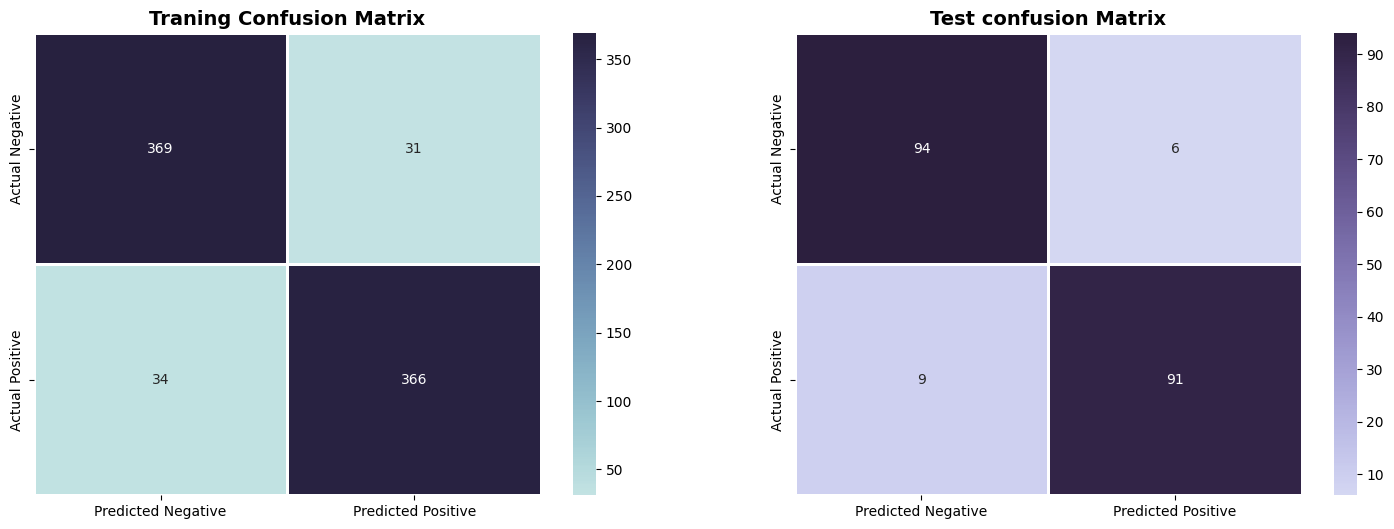

In [8]:
# Re-initialize SVM with the best tolerance

svm = SVM(kernel='gaussian', C=0.1, gamma=0.01,solver="mvp",tol=1e-5)

# Train the final model
svm.fit(X_train, y_train)

# Calculate accuracies
y_train_pred = svm.predict(X_train)
train_accuracy = svm.score(y_train_pred, y_train)

y_test_pred = svm.predict(X_test)
test_accuracy = svm.score(y_test_pred, y_test)

svm.report_metrics()

print(f"\nAccuracy Results:")
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Duality gap: {svm.duality_gap:.3f}\n")

plot_confusion_matrix(y_train,y_train_pred,y_test,y_test_pred)


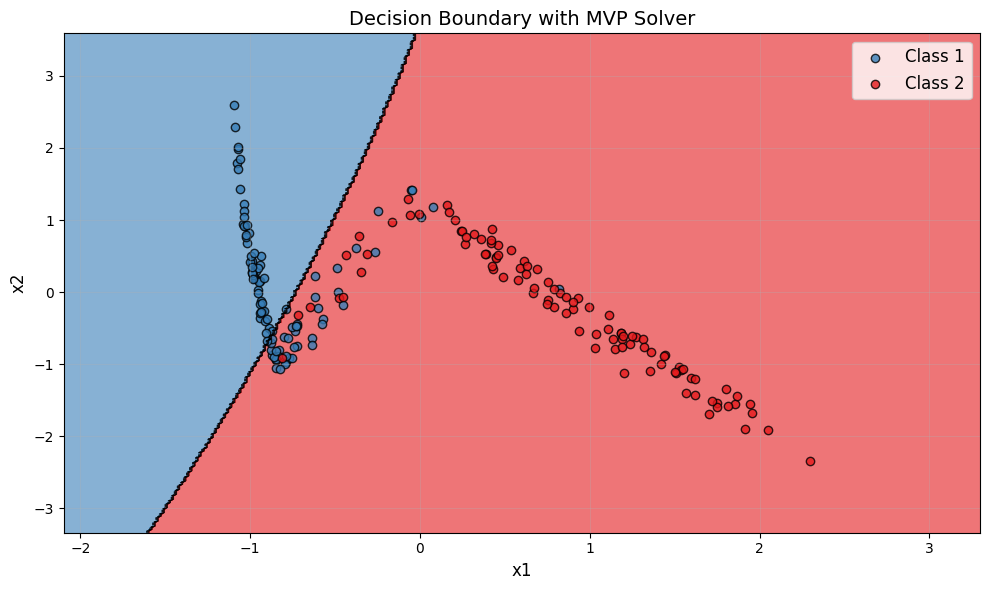

In [9]:
X = X_test[:,:2]  # Use only the first two features for visualization
y = y_test
svm.fit(X, y)  # Retrain SVM on the two features for visualization

plot_decision_boundary(svm, X, y,title="Decision Boundary with MVP Solver")

# Question 4 BONUS

Dataset: `ETHNICITY CLASSIFICATION.csv`

Consider a three classes problem with three out of the five ethnicities in the dataset. Implement an SVM strategy for multiclass classification (either one against one or one
against all).


In [10]:
# Load dataset
ethnicity = pd.read_csv("ETHNICITY_CLASSIFICATION.csv")

## 4.1 Ethnicity Dataset Triplet Analysis
This analysis focuses on finding the optimal combination of three ethnicity classes from a five-class dataset using Support Vector Machine (SVM) classification. We systematically evaluate all possible triplet combinations to identify the best performing subset based on accuracy metrics and duality gap of *CVXOPT* solver with *Gaussian Kernel*.
These combinations are generated using Python’s `itertools.combinations` function.
For each triplet, the following steps are performed:
1.	**Data Filtering**: Select only the samples belonging to the current triplet of classes;
2.	**Feature Standardization**: Apply StandardScaler to normalize input features;
3.	**Stratified Splitting**: Divide data into training and testing sets with preserved class proportions;
4.	**Model Training**: Train a One-vs-All (OvA) SVM using the CVXOPT solver with a Gaussian kernel;
5.	**Evaluation**: Measure performance using:
- *Training and Testing Accuracy*
- *Duality Gap* : indicating convergence quality of the dual optimization problem.


**Warning: the running time to compute all possible triplets is approximately 1 minute 30s.**

In [11]:
from itertools import combinations
from tqdm import tqdm

# Initialize a list to store evaluation results for each triplet
triplet_results = []

# Generate all possible triplets from classes
all_triplets = list(combinations([0, 1, 2, 3, 4], 3))

for triplet in tqdm(all_triplets,"Number of triplet examined",len(all_triplets),colour="green"):
    # Filter the dataset to include only the current triplet classes
    filter_ethnicity = ethnicity[ethnicity["gt"].isin(triplet)]

    # Extract features and labels
    X = filter_ethnicity.drop("gt", axis=1).values
    y = filter_ethnicity["gt"].values

    # Standardize
    scaler = StandardScaler()
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize SVM with OvA strategy
    svm = SVM(C=0.1,gamma=0.01,decision_function_shape="ova")
    svm.fit(X_train, y_train)

    # Training accuracy
    y_train_pred = svm.predict(X_train)
    train_accuracy = svm.score(y_train_pred, y_train)

    # Test accuracy
    y_test_pred = svm.predict(X_test)
    test_accuracy = svm.score(y_test_pred, y_test)

    # Store results for this triplet
    data = {"Triplet": triplet,
        "Train Accuracy": round(train_accuracy, 3),
        "Test Accuracy": round(test_accuracy, 3),
        "CPU Time(s)": round(svm.CPU_time, 2),
        "Duality Gap" : round(svm.duality_gap,2)}

    triplet_results.append(data)

triplet_df = pd.DataFrame(triplet_results)

# Sort by test accuracy (descending order)
triplet_df = triplet_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

# Show the final DataFrame
triplet_df

Number of triplet examined: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


,Triplet,Train Accuracy,Test Accuracy,CPU Time(s),Duality Gap
0,"(0, 1, 2)",0.907,0.890,4.26,1.01
1,"(0, 1, 3)",0.882,0.877,2.55,1.28
2,"(1, 2, 3)",0.912,0.870,2.53,0.95
3,"(0, 2, 3)",0.879,0.867,2.36,0.96
4,"(2, 3, 4)",0.815,0.827,2.51,0.99
5,"(1, 2, 4)",0.875,0.820,2.59,0.96
6,"(0, 1, 4)",0.812,0.813,2.94,1.29
7,"(0, 2, 4)",0.811,0.810,2.36,1.23
8,"(0, 3, 4)",0.746,0.780,2.25,1.52
9,"(1, 3, 4)",0.817,0.760,2.52,1.34


## One Vs All strategy

Dual objective (initial): 0.00
Dual objective (final): 27.87
Number of Iterations: 13
Bias: -0.35
Number of Support Vectors: 355
Max alpha value: 0.1
Min non-zero alpha: 0.0
CPU Time: 2.49 seconds

Training accuracy: 0.907
Test accuracy: 0.890
Duality Gap: 1.01



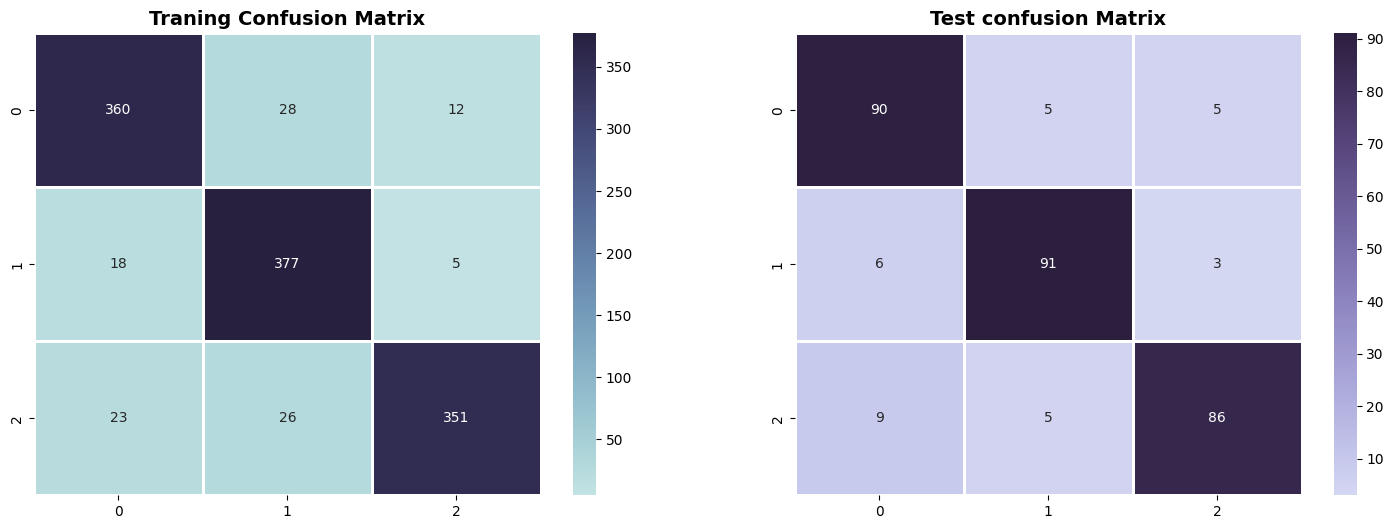

In [12]:
# Filter dataset for specific triplet of classes
filter_ethnicity = ethnicity[ethnicity["gt"].isin([0,1,2])]

# Extract features and labels
X = filter_ethnicity.drop("gt", axis=1).values
y = filter_ethnicity["gt"].values

labels = np.unique(y)

# Standardize
scaler = StandardScaler()

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVM(C=0.1, gamma=0.01, decision_function_shape="ova")
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
train_accuracy=svm.score(y_train_pred, y_train)

y_test_pred = svm.predict(X_test)
test_accuracy = svm.score(y_test_pred, y_test)

svm.report_metrics()

print(f"\nTraining accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Duality Gap: {svm.duality_gap:.2f}\n")

plot_confusion_matrix(y_train,y_train_pred,y_test,y_test_pred,mode="multiclass")


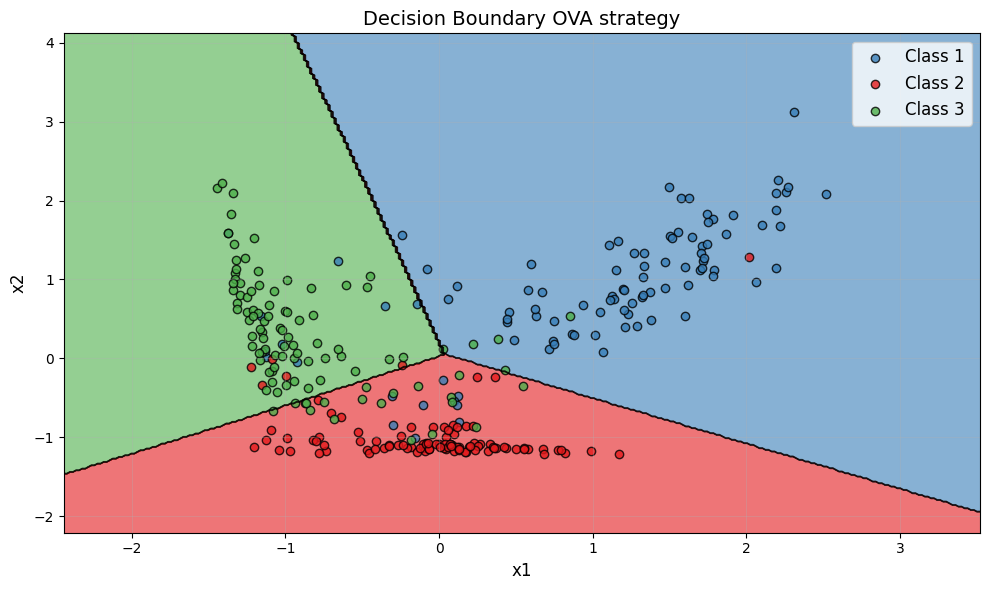

In [13]:
X = X_test[:,:2]  # Use only the first two features for visualization
y = y_test
svm.fit(X, y)  # Retrain SVM on the two features for visualization

plot_decision_boundary(svm, X, y,title="Decision Boundary OVA strategy")

Dual objective (initial): 0.00
Dual objective (final): 26.73
Number of Iterations: 269
Bias: -0.43
Number of Support Vectors: 305
Max alpha value: 0.1
Min non-zero alpha: 0.0
CPU Time: 0.47 seconds

Training accuracy: 0.905
Test accuracy: 0.887
Duality Gap: 8.68



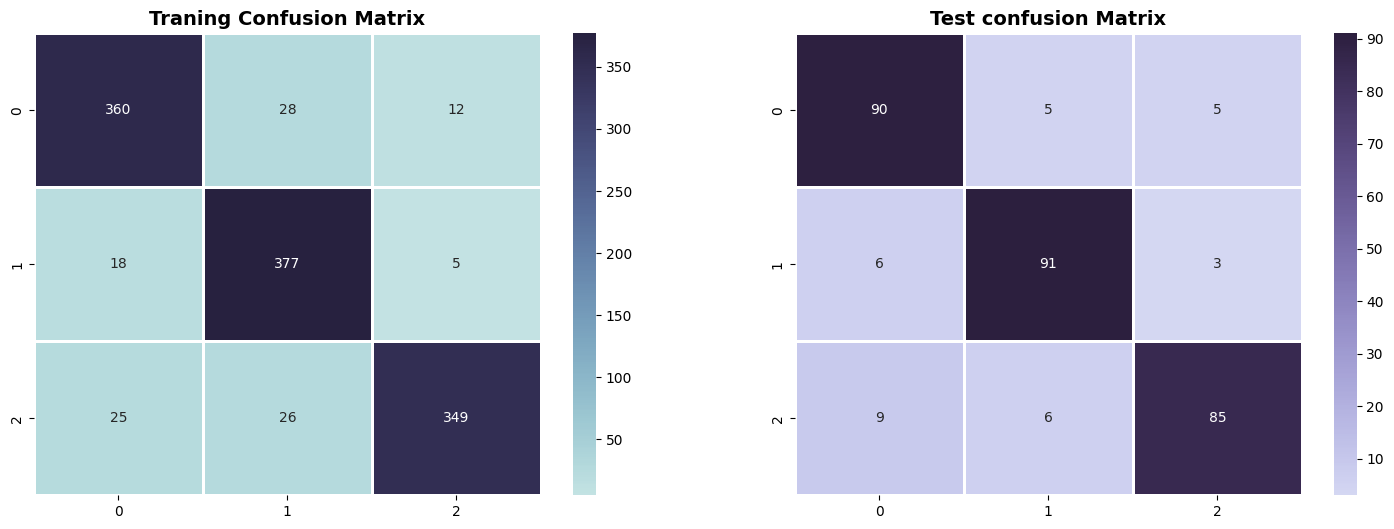

In [14]:
# Re-initialize SVM with the best parameters for the training phase
svm = SVM(C=0.1, gamma=0.01, decision_function_shape="ova",solver="mvp",tol=1e-5)
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
train_accuracy=svm.score(y_train_pred, y_train)

y_test_pred = svm.predict(X_test)
test_accuracy = svm.score(y_test_pred, y_test)

svm.report_metrics()

print(f"\nTraining accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Duality Gap: {svm.duality_gap:.2f}\n")

plot_confusion_matrix(y_train,y_train_pred,y_test,y_test_pred,mode="multiclass")



## One Vs One Strategy

Dual objective (initial): 0.00
Dual objective (final): 20.38
Number of Iterations: 13
Bias: 0.08
Number of Support Vectors: 265
Max alpha value: 0.1
Min non-zero alpha: 0.0
CPU Time: 0.68 seconds

Training accuracy: 0.902
Test accuracy: 0.890
Duality Gap: 0.03



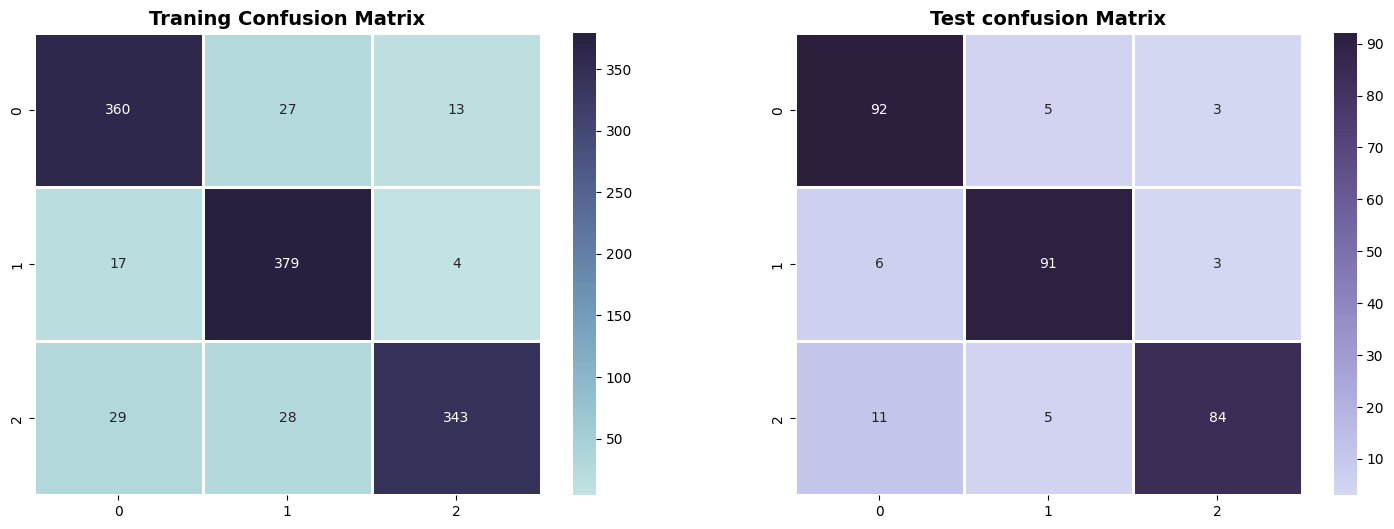

In [15]:
# Re-initialize SVM with with OvO strategy and the CVXOPT solver (default solver of SVM)

svm = SVM(C=0.1, gamma=0.01, decision_function_shape="ovo")
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
train_accuracy=svm.score(y_train_pred, y_train)

y_test_pred = svm.predict(X_test)
test_accuracy = svm.score(y_test_pred, y_test)

svm.report_metrics()

print(f"\nTraining accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Duality Gap: {svm.duality_gap:.2f}\n")

plot_confusion_matrix(y_train,y_train_pred,y_test,y_test_pred,mode="multiclass")


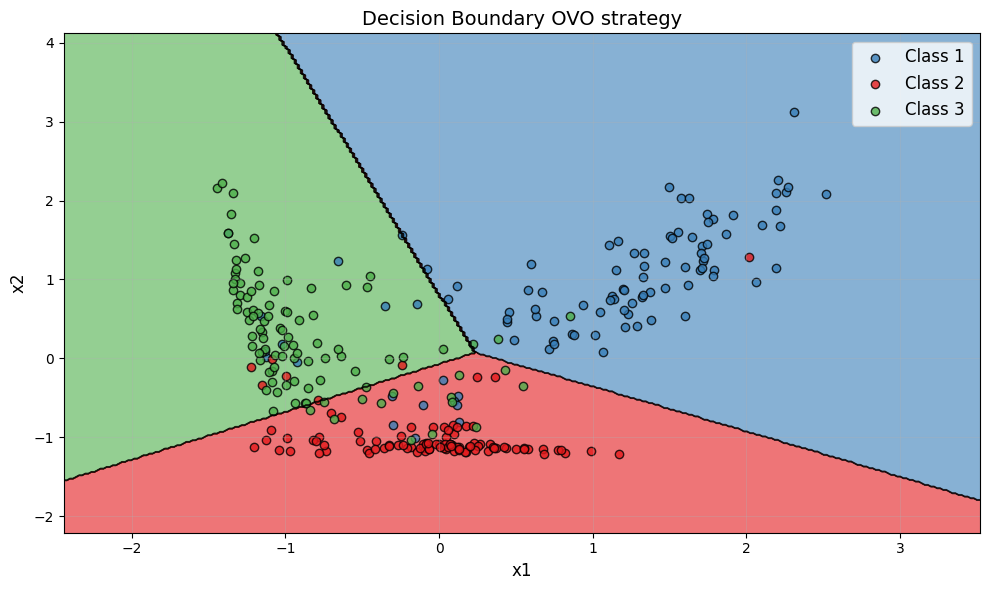

In [16]:
X = X_test[:,:2]  # Use only the first two features for visualization
y = y_test
svm.fit(X, y)  # Retrain SVM on the two features for visualization

plot_decision_boundary(svm, X, y,title="Decision Boundary OVO strategy")

Dual objective (initial): 0.00
Dual objective (final): 20.26
Number of Iterations: 497
Bias: 0.16
Number of Support Vectors: 253
Max alpha value: 0.1
Min non-zero alpha: 0.0
CPU Time: 1.11 seconds

Training accuracy: 0.900
Test accuracy: 0.887
Duality Gap: 0.76



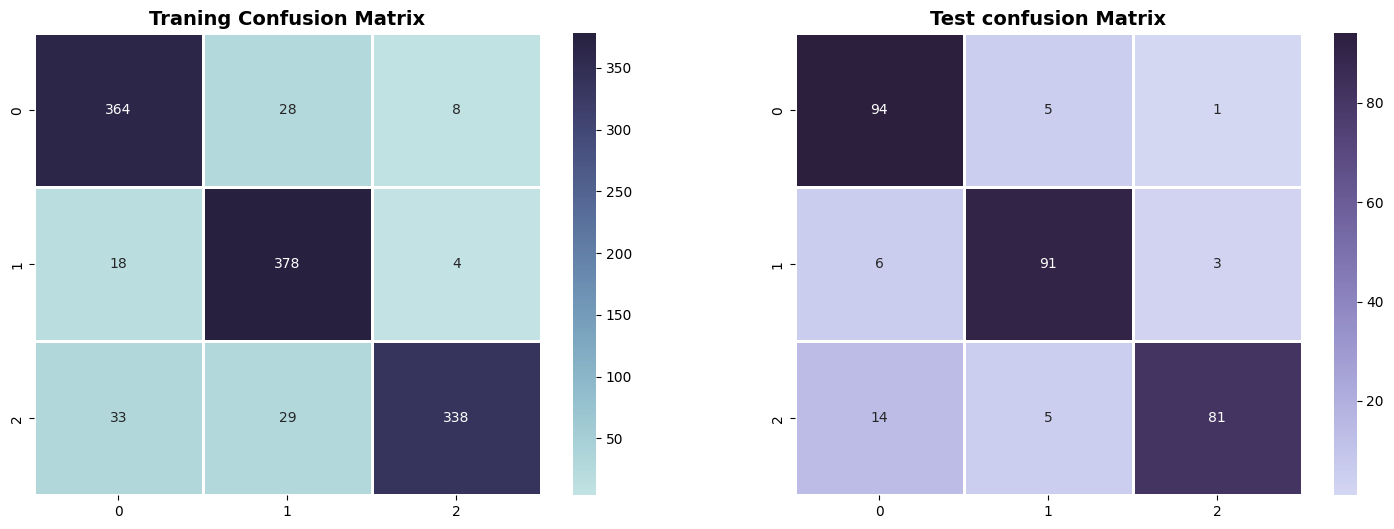

In [17]:
# Re-initialize SVM with with OvO strategy and the Most Violating Pair Solver

svm = SVM(C=0.1, gamma=0.01, decision_function_shape="ovo",solver="mvp",tol=1e-5)
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
train_accuracy=svm.score(y_train_pred, y_train)

y_test_pred = svm.predict(X_test)
test_accuracy = svm.score(y_test_pred, y_test)

svm.report_metrics()

print(f"\nTraining accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Duality Gap: {svm.duality_gap:.2f}\n")

plot_confusion_matrix(y_train,y_train_pred,y_test,y_test_pred,mode="multiclass")